In [1]:
# from tosig_pytorch import EsigPyTorch
from free_lie_algebra import *
from logsignature import *
import bch

from esig import tosig
import iisignature

import pandas as pd
from time import time
import torch
import seaborn as sns
import scipy.sparse as sp
import numpy as np
from collections import defaultdict
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Experiments with log-signatures calculations

In [2]:
def get_anagrams(source):
    d = defaultdict(list)
    for word in source:
        key = "".join(sorted(word))
        d[key].append(word)
    return d

def print_anagrams(word_source):
    d = get_anagrams(word_source)
    for key, anagrams in d.items():
        if len(anagrams) > 1:
            print(key, anagrams)

In [143]:
# define dimensions of the problem
level = 4
width = 4
lyndon = True

In [144]:
# fix a Hall basis of the free Lee Algebra
if not lyndon:
    Hall_basis = HallBasis(m=level, d=width, lessExpression=lessExpressionStandardHall) # Coropa Hall basis
else:
    Hall_basis = HallBasis(m=level, d=width, lessExpression=lessExpressionLyndon) # Lyndon basis

In [145]:
# Construct a basis for the Tensor Algebra 
Tensor_basis = TensorSpaceBasis(fn=word2Elt, basis=Hall_basis) # standard tensor space basis
# Tensort_basis = TensorSpaceBasis(fn=P, basis=Hall_basis) # Poincare-Birhoff-Witt basis
# Tensort_basis = TensorSpaceBasis(fn=S, basis=Hall_basis) # Dual of Poincare-Birhoff-Witt basis

In [146]:
# let's see what we are dealing with
total_hall_elts = 0
for lev in range(level):
    total_hall_elts += len(Hall_basis.data[lev])
    print('The foliages of hall words at level {} are: {}'.format(lev+1, [foliageFromTree(r) for r in Hall_basis.data[lev]]))
print('\n For width = {} and depth = {}, in total we have {} Hall basis elements in the free Lie Algebra'.format(width, level, total_hall_elts))

The foliages of hall words at level 1 are: ['1', '2', '3', '4']
The foliages of hall words at level 2 are: ['12', '13', '14', '23', '24', '34']
The foliages of hall words at level 3 are: ['112', '113', '114', '122', '123', '124', '132', '133', '134', '142', '143', '144', '223', '224', '233', '234', '243', '244', '334', '344']
The foliages of hall words at level 4 are: ['1112', '1113', '1114', '1122', '1123', '1124', '1132', '1133', '1134', '1142', '1143', '1144', '1213', '1214', '1222', '1223', '1224', '1232', '1233', '1234', '1242', '1243', '1244', '1314', '1322', '1323', '1324', '1332', '1333', '1334', '1342', '1343', '1344', '1422', '1423', '1424', '1432', '1433', '1434', '1442', '1443', '1444', '2223', '2224', '2233', '2234', '2243', '2244', '2324', '2333', '2334', '2343', '2344', '2433', '2434', '2443', '2444', '3334', '3344', '3444']

 For width = 4 and depth = 4, in total we have 90 Hall basis elements in the free Lie Algebra


In [147]:
# dictionary level i : hall words in level i
hall_words = {}
for lev in range(level):
    hall_words['level {}'.format(lev+1)] = [foliageFromTree(r) for r in Hall_basis.data[lev]]

In [148]:
# dictionary level i : anagram equivalence classes in level i
anagram_classes = {'level {}'.format(lev+1):list(get_anagrams(hall_words['level {}'.format(lev+1)]).keys()) for lev in range(level)}
print('These are the anagram equivalence classes: \n')
anagram_classes

These are the anagram equivalence classes: 



{'level 1': ['1', '2', '3', '4'],
 'level 2': ['12', '13', '14', '23', '24', '34'],
 'level 3': ['112',
  '113',
  '114',
  '122',
  '123',
  '124',
  '133',
  '134',
  '144',
  '223',
  '224',
  '233',
  '234',
  '244',
  '334',
  '344'],
 'level 4': ['1112',
  '1113',
  '1114',
  '1122',
  '1123',
  '1124',
  '1133',
  '1134',
  '1144',
  '1222',
  '1223',
  '1224',
  '1233',
  '1234',
  '1244',
  '1333',
  '1334',
  '1344',
  '1444',
  '2223',
  '2224',
  '2233',
  '2234',
  '2244',
  '2333',
  '2334',
  '2344',
  '2444',
  '3334',
  '3344',
  '3444']}

In [149]:
# map angram class -> hall words
anagram_hall_words_map = {}
for lev in range(level):
    for anagram in anagram_classes['level {}'.format(lev+1)]:
        anagram_hall_words_map[anagram] = get_anagrams(hall_words['level {}'.format(lev+1)])[anagram]
# print('Mapping anagram equivalence classes ----> Hall words: \n')
# anagram_hall_words_map

In [150]:
# letters count in foliages of anagram classes
anagram_letter_counts = {}
for anag in anagram_hall_words_map.keys():
    anagram_letter_counts[anag] = [anag.count(str(let)) for let in range(1, width+1)]
    
# show in dataframe
df = pd.DataFrame.from_dict(anagram_letter_counts).T
df.columns=['# of "{}"'.format(let) for let in range(1, width+1)]
df = df.rename_axis('anagram equivalence classes')
df.head()

,"# of ""1""","# of ""2""","# of ""3""","# of ""4"""
anagram equivalence classes,,,,
1,1,0,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1
12,1,1,0,0


In [151]:
hall_anagrams_expansion_in_tensor_space_indices = {}
for anag, ind in anagram_letter_counts.items():
    hall_anagrams_expansion_in_tensor_space_indices[anag] = Tensor_basis.indicesOfAnagramSet(ind, True)

# print('These are the indices of the elements in tensor space corresponding to words appearing in the expansion of the Lie bracketed expression whose foliage is an anagram class')
# hall_anagrams_expansion_in_tensor_space_indices

Given the bracketed expression of a hall basis element with $m$ letters, we find its expanded expression in Tensor Space by multiplying out the brackets (!). This gives is the matrix $M_m$ to transform each level of the log-signature to its expanded version (i.e. $L2T$). Each column of $M_m$ is labelled with a hall basis element, and each row is labelled with one of the $d^m$ words of length $d$. 

In [152]:
# list all basis elements of the tensor algebra
tensor_space_basis_elements = []
for i in Tensor_basis.generateWordsElts():
    tensor_space_basis_elements.append(i[0])

In [153]:
# generate L2T matrix
basisElts = [i for level in Hall_basis.data for i in level]
basisTensors = [Tensor_basis.fromElt(basisElementToElt(i)) for i in basisElts]
projection_matrix = np.array(basisTensors).T
df_l2t = pd.DataFrame(projection_matrix, 
                      index=tensor_space_basis_elements,
                      columns=[foliageFromTree(h) for h in [h for level in Hall_basis.data for h in level]])
# df_l2t

So if we have the values $x_m$ of the $m^{th}$ level of log-signature in expanded Tensor Space, we can determine its values $c_m$ in the free Lie Algebra in a pre-specified Hall basis by solving the following (over-determined) system of equations:

$$M_mc_m=x_m$$

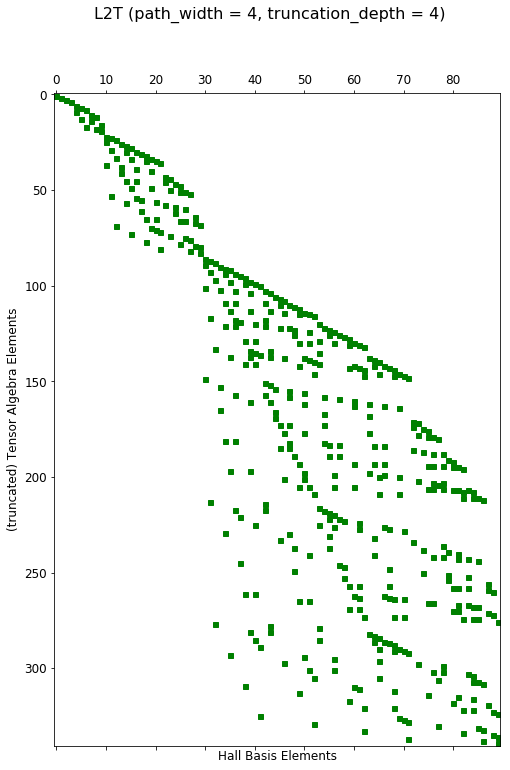

In [154]:
mat = sp.csr_matrix(projection_matrix)
dims = (8, 12)
fig, ax = plt.subplots(figsize=dims)
plt.spy(mat, markersize=5, color='g', aspect='auto')
fig.suptitle('L2T (path_width = {}, truncation_depth = {})'.format(width, level), fontsize=16)
plt.ylabel('(truncated) Tensor Algebra Elements', fontsize=12)
plt.xlabel('Hall Basis Elements', fontsize=12)
plt.show()

The words (in tensor space) occurring in the expansion of a Lie bracketed expression are $anagrams$ of the $foliage$ of the expression. In Reutenauer's terms, the bracketing and un-bracketing operations preserve the $fine \ homogeneity$. For example 

$$[[1,3],3] = 133 - 2*313 + 331$$

Permuting the rows and columns to gather anagrams makes the $m^{th}$ level of the $L2T$ projection matrix be a block diagonal matrix.

In [155]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

level: 1 



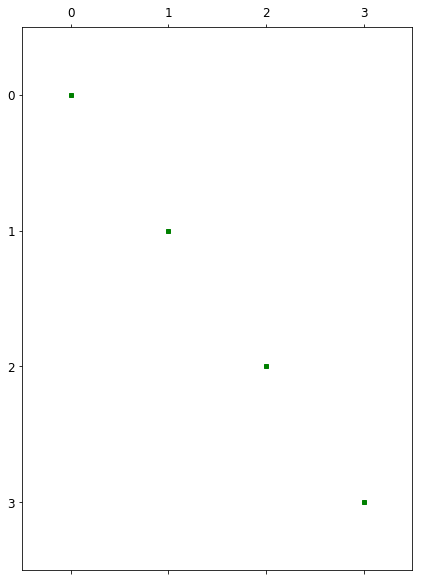

level: 2 



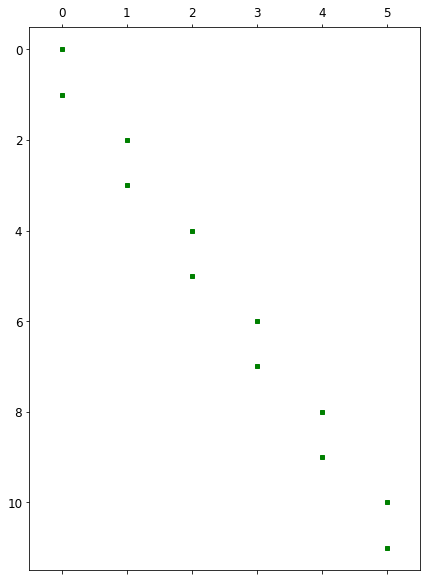

level: 3 



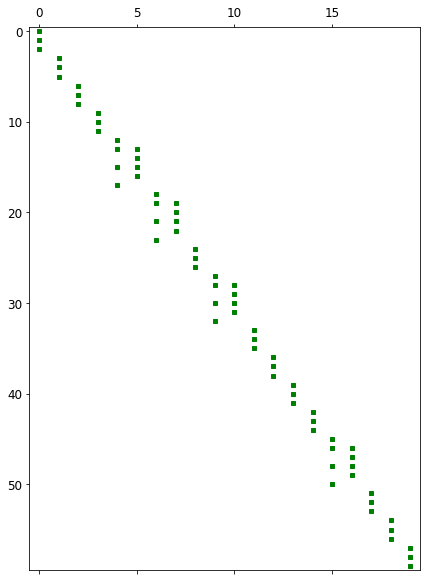

level: 4 



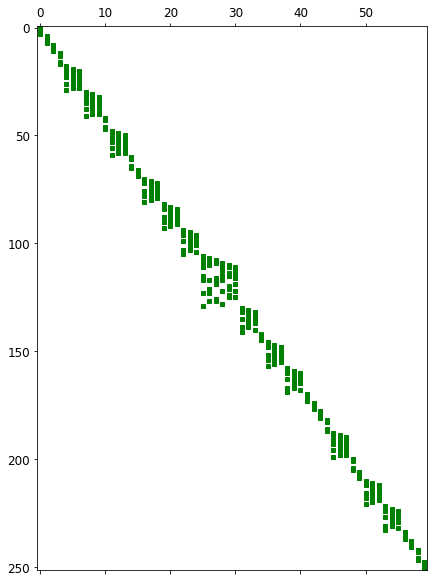

In [156]:
matrices = {}
for lev in range(1, level+1):
    M_lev = df_l2t.iloc[Tensor_basis.indexOfLevelStart(lev):Tensor_basis.indexOfLevelStart(lev+1),:]
    M_lev = M_lev[flatten_list([anagram_hall_words_map[b] for b in anagram_classes['level {}'.format(lev)]])]
    tensor_indices = [hall_anagrams_expansion_in_tensor_space_indices[anag] for anag in anagram_classes['level {}'.format(lev)]]
    matrices['level {}'.format(lev)] = {an:M_lev.iloc[t_ind,:][anagram_hall_words_map[an]] for an,t_ind in zip(anagram_classes['level {}'.format(lev)], tensor_indices)}
    tensor_indices_flatten = flatten_list(tensor_indices)
    M_lev = M_lev.iloc[tensor_indices_flatten,:]
    print('level: {} \n'.format(lev))
#     print(M_lev)
    dims = (7, 10)
    fig, ax = plt.subplots(figsize=dims)
    plt.spy(M_lev.values, markersize=4, color='g', aspect='auto')
    plt.show()

We can save time doing the transformation by solving a separate linear system for each equivalence class of anagrams of words of length $m$.

Hence, we determine all the mapping matrices between anagram classes of the log signature and its expansion, and then we calculate all their Moore-Penrose pseudoinverses, so that solving the systems is just a matrix multiplication.

The pseudo-inverse of a matrix $A$, denoted $A^+$, is defined as: “the matrix that solves the least squares problem $Ax = b$ ",  i.e., if $\bar{x}$ is said solution, then $A^+$ is that matrix such that $\bar{x} = A^+b$.

It can be shown that if $Q_1 \Sigma Q_2^T = A$ is the singular value decomposition of $A$, then $A^+ = Q_2 \Sigma^+ Q_1^T$, where $Q_{1,2}$ are orthogonal matrices, $\Sigma$ is a diagonal matrix consisting of A’s so-called singular values, (followed, typically, by zeros), and then $\Sigma^+$ is simply the diagonal matrix consisting of the reciprocals of A’s singular values (again, followed by zeros).

In the Lyndon basis we can actually do better...

### Theorem 5.1 of Reutenauer:

The set of Lyndon words, ordered alphabetically, is a Hall set. The corresponding Hall basis has the following triangularity
property: for each word $w = l_1...l_n$ written as a decreasing product of Lyndon words, the polynomial $P_w = P_{l_1}...P_{l_n}$ is equal to $w$ plus a Z-linear combination of greater words.

Therefore, When the bracketed expression corresponding to a Lyndon word is expanded and terms are collected and ordered in alphabetical order of the word, the first term will be the Lyndon word itself, with coefficient 1.

This means that the projection matrix $L2T$ is actually lower triangular and so are the matrices of its anagram equivalence classes. 

Hence, If we take such a block and remove all the rows corresponding to words which are not Lyndon, we are left with the mapping from an anagram equivalence class in the log signature expressed in a Hall basis of the free Lie Algebra to same Lyndon word elements of the expanded signature. It is a square lower triangular matrix with ones on the diagonal, so we can solve the system of equations much more simply and quickly.

In [157]:
if not lyndon:
    pseudo_inverses = {}
    for lev in range(1, level+1):    
        pseudo_inverses_level = {}
        for anag, mat in matrices['level {}'.format(lev)].items():
            pseudo_inverses_level[anag] = pd.DataFrame(np.linalg.pinv(mat.values), index=mat.columns, columns=mat.index)
        pseudo_inverses['level {}'.format(lev)] = pseudo_inverses_level
else:
    lyndon_matrices = {}
    for lev in range(1, level+1):
        lyndon_matrices_level = {}
        for anag, mat in matrices['level {}'.format(lev)].items():
            lyn_words = []
            for word in mat.index: #check which are lyndon words
                if len(word)>0 and 1==len(Hall_basis.factorIntoHallWords(word)):
                    lyn_words.append(word)
            lyndon_matrices_level[anag] = mat.loc[lyn_words,:]
        lyndon_matrices['level {}'.format(lev)] = lyndon_matrices_level

### Example of anagram equivalence class matrices in the Lyndon basis

      1224  1242  1422
1224   1.0   0.0   0.0
1242  -2.0   1.0   0.0
1422   1.0  -1.0   1.0
2124   0.0  -1.0   0.0
2142   0.0   1.0  -2.0
2214   0.0   0.0   1.0
2241  -1.0   1.0  -1.0
2412   0.0  -1.0   2.0
2421   2.0  -1.0   0.0
4122   0.0   0.0  -1.0
4212   0.0   1.0   0.0
4221  -1.0   0.0   0.0


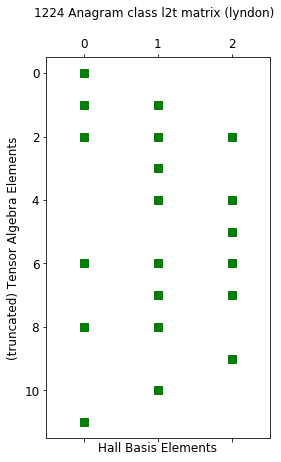

In [175]:
anagr = '1224'
leve = 4
print(matrices['level {}'.format(leve)][anagr])
mat = sp.csr_matrix(matrices['level {}'.format(leve)][anagr].values)
dims = (4, 7)
fig, ax = plt.subplots(figsize=dims)
plt.spy(mat, markersize=8, color='g', aspect='auto')
fig.suptitle('{} Anagram class l2t matrix (lyndon)'.format(anagr), fontsize=12)
plt.ylabel('(truncated) Tensor Algebra Elements', fontsize=12)
plt.xlabel('Hall Basis Elements', fontsize=12)
plt.show()

      1224  1242  1422
1224   1.0   0.0   0.0
1242  -2.0   1.0   0.0
1422   1.0  -1.0   1.0


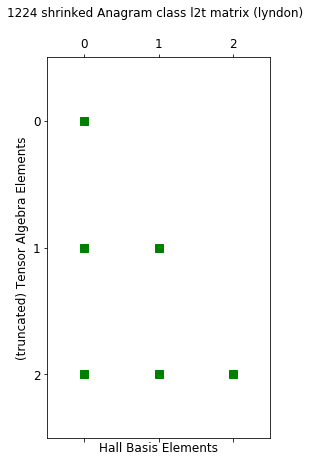

In [176]:
print(lyndon_matrices['level {}'.format(leve)][anagr])
mat = sp.csr_matrix(lyndon_matrices['level {}'.format(leve)][anagr].values)
dims = (4, 7)
fig, ax = plt.subplots(figsize=dims)
plt.spy(mat, markersize=8, color='g', aspect='auto')
fig.suptitle('{} shrinked Anagram class l2t matrix (lyndon)'.format(anagr), fontsize=12)
plt.ylabel('(truncated) Tensor Algebra Elements', fontsize=12)
plt.xlabel('Hall Basis Elements', fontsize=12)
plt.show()

## Example

In [158]:
path = np.random.rand(100, width)

In [159]:
# truncated signature of the path
sig = signature_of_path_manual(path, level)

# log-signature in tensor form
log_sig_tensor = Tensor_basis.fromElt(log(sig))

# log-signature dataframe
log_sig_df = pd.DataFrame(log_sig_tensor, index=tensor_space_basis_elements,columns=['log-signature'])

A = {}
if not lyndon:
    for lev in range(1, level+1):
        for anag, inv_mat in pseudo_inverses['level {}'.format(lev)].items():
            pseudo_inverse_anagram_matrix = inv_mat.values
            log_sig_elt = log_sig_df.T[inv_mat.columns].values.T
            values = np.dot(pseudo_inverse_anagram_matrix, log_sig_elt)
            for ind, val in zip(inv_mat.index, values):
                A[ind] = val[0]
else:
    for lev in range(1, level+1):
        for anag, lyn_mat in lyndon_matrices['level {}'.format(lev)].items():
            lyndon_anagram_matrix = lyn_mat.values
            log_sig_lyn_elt = log_sig_df.T[lyn_mat.columns].values.T
            values = scipy.linalg.solve_triangular(lyndon_anagram_matrix, log_sig_lyn_elt, lower=True, unit_diagonal=True)
            for ind, val in zip(lyn_mat.index, values):
                A[ind] = val[0]
            
my_log_sig = np.array([A[n] for n in flatten_list(list(hall_words.values()))])

In [160]:
esig_log_sig = tosig.stream2logsig(path, level)

s = iisignature.prepare(width, level)
iisig_log_sig = iisignature.logsig(path, s)

In [161]:
if not lyndon:
    print(np.sum(my_log_sig - esig_log_sig))
else:
    print(np.sum(my_log_sig - iisig_log_sig))

-1.5612511283791264e-16


# Analysis of sparsity

We know that the total number of words contained in an anagram equivalence class of anagrams composed by $m$ letters where the frequency of the $k^{th}$ letter in $f_k$ is given by the multinomial coefficient:

$$card \ \ A_{l_1,...,l_k,...,l_d}^{(m)} = \frac{m!}{f_1!...f_k!...f_d!}$$

We also know that the number of of Lie basis elements in an anagram equivalence class is given by the second Witt formula of Satz 3:

$$card \ \ Lie_{A_{l_1,...,l_k,...,l_d}^{(m)}}$$

## Tensor -> Lie

In [188]:
# def Tensor2Lie(lie_tensor, width, depth, Hall_basis, tensor_space_basis):
    
#     """Express lie_tensor in a given Hall basis where lie_tensor is a tensor which is known to be in the FLA"""
    
#     # numerical coordinates of the input tensor as array
#     coords = tensor_space_basis.fromElt(lie_tensor)
    
#     # projection tensor -> lie
#     lie_coefficients_in_Hall_basis = {}
#     for word, coeff in zip(wordIter(width, depth, asNumbers=True), coords):
#         if len(word)>0 and 1==len(Hall_basis.factorIntoHallWords(word)): # check if word is a Hall word
#             lie_coefficients_in_Hall_basis[foliageFromTree(word)] = coeff

#     return lie_coefficients_in_Hall_basis, np.fromiter(lie_coefficients_in_Hall_basis.values(), dtype=float)

## Log-Signature via $\pi_1^T$ and the dual of the PBW basis, S

In [20]:
# dimensions of the problem
width, depth = 2, 4

# random path
path = np.random.rand(100, width)

# truncated signature of the path
sig = signature_of_path_manual(path, depth)

# log-signature in tensor form
x = log(sig)

# pick a Hall basis
H=HallBasis(2,4)
    #H=HallBasis(2,4,lessExpressionStandardHall)

### $log(X)_h = <S_h, log(X)>$

In [2]:
for h in [h for level in H.data for h in level]:
    print("coefficient of "+printTreeAsLieBrackets(h)+" is "+str(dotprod(S(foliageFromTree(h),H),x)))

NameError: name 'H' is not defined

### $log(X)_h = <\pi_1^T(S_h), X>$

In [22]:
for h in [h for level in H.data for h in level]:
    print("coefficient of "+printTreeAsLieBrackets(h)+" is "+str(dotprod(pi1adjoint(S(foliageFromTree(h),H)), sig)))

coefficient of 1 is -0.7621496484686451
coefficient of 2 is 0.7502142303225249
coefficient of [1,2] is -0.29392222108294747
coefficient of [1,[1,2]] is 0.07168418717055208
coefficient of [[1,2],2] is 0.07697571572459917
coefficient of [1,[1,[1,2]]] is 0.0019250768548041083
coefficient of [1,[[1,2],2]] is 0.03123438038431585
coefficient of [[[1,2],2],2] is 0.0025628462139798925


In [23]:
s = iisignature.prepare(width, depth)
iisignature.logsig(path, s)

array([-0.76214965,  0.75021423, -0.29392222,  0.07168419,  0.07697572,
        0.00192508,  0.03123438,  0.00256285])

## Log-Signature via Baker-Cambell-Hausdorff

In [25]:
p = np.random.rand(100, 2)
bch.getLogSigOfPath(p, 5)

array([-0.31808642,  0.6311234 ,  0.59898955, -0.257838  ,  0.17450468,
        0.04811506, -0.06653128,  0.02692653, -0.0058897 ,  0.01368729,
       -0.01186183,  0.03404824, -0.04833767,  0.00236711], dtype=float32)

# Sparsity Analysis of T2L and L2T

In [2]:
from tosig_pytorch import *

do you want to use the lyndon basis? (yes or no)no


## Sparse matrices

### 1) T2L

In [3]:
# define dimension of the problem
width = 5
depth = 5

# generate brownian path
pyt = EsigPyTorch()
path = pyt.brownian(100, width)

# calculate log-signatures via t2l and store values in dictionary (sparse representation)
log_sigs = pyt.stream2logsig(path, depth)

# define a pandas dataframe with sparse matrix
df = pd.DataFrame.from_dict(pyt.rbraketing_cache).T
df.index = [k[0] for k in pyt.rbraketing_cache.keys()]
df = df.stack(dropna=False).apply(lambda x: x.tolist() if not isinstance(x, float) else x).unstack().fillna(0.).T

# create scipy sparse matrix
mat = sp.csr_matrix(df.values)

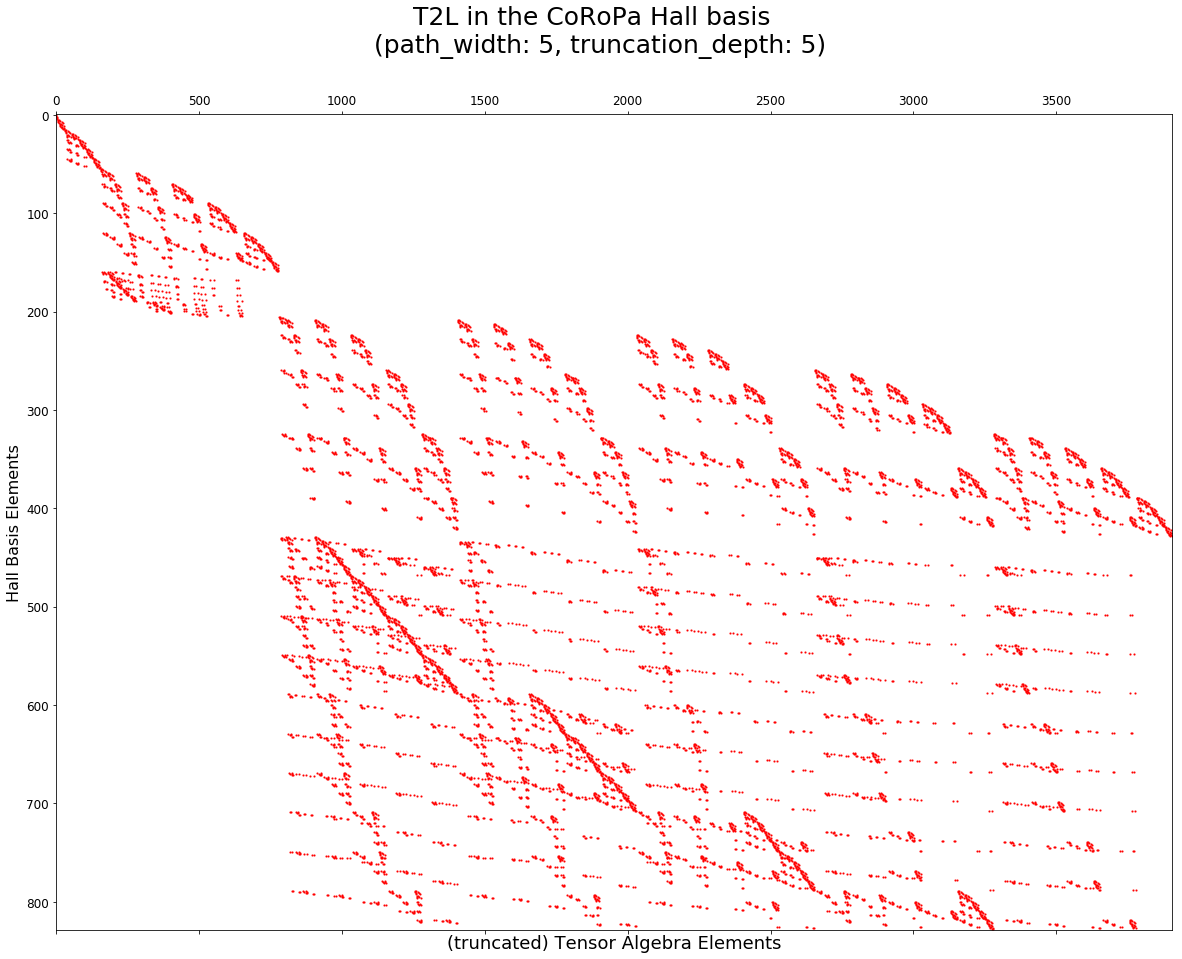

In [4]:
# plot results
dims = (20, 15)
fig, ax = plt.subplots(figsize=dims)
plt.spy(mat, markersize=1, color='r', aspect='auto')
fig.suptitle('T2L in the CoRoPa Hall basis \n (path_width: {}, truncation_depth: {})'.format(width, depth), fontsize=25)
plt.xlabel('(truncated) Tensor Algebra Elements', fontsize=18)
plt.ylabel('Hall Basis Elements', fontsize=16)
plt.savefig('t2l_coropa.png')
plt.show()

### 2) L2T (same procedure as before)

In [5]:
pyt = EsigPyTorch()
path = pyt.brownian(100, width)
t = pyt.l2t(pyt.t2l(pyt.stream2sigtensor(pyt.brownian(100, width), depth)), width, depth)

expand_new = {}
for a, b in pyt.expand_cache.items():
    values_list = b.tolist()
    if len(values_list) < pyt.sigdim(width, depth) + 1:
        k = pyt.sigdim(width, depth) + 1 - len(values_list)
        values_list = values_list + k*[0.]
    expand_new[a[0]] = values_list
    
df = pd.DataFrame.from_dict(expand_new).T.sort_index()

mat = sp.csr_matrix(df.values)

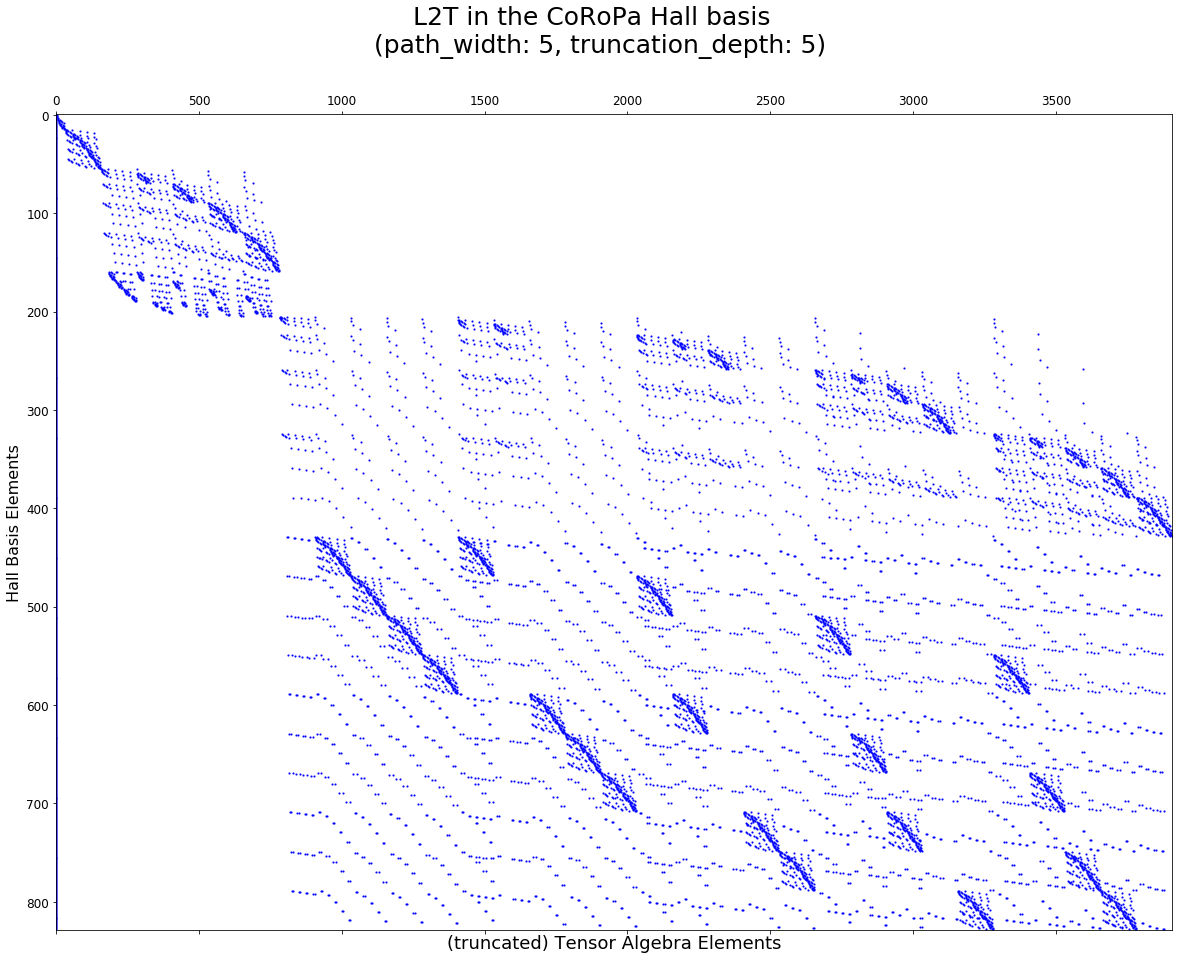

In [6]:
dims = (20, 15)
fig, ax = plt.subplots(figsize=dims)
plt.spy(mat, markersize=1, color='b', aspect='auto')
fig.suptitle('L2T in the CoRoPa Hall basis \n (path_width: {}, truncation_depth: {})'.format(width, depth), fontsize=25)
plt.xlabel('(truncated) Tensor Algebra Elements', fontsize=18)
plt.ylabel('Hall Basis Elements', fontsize=16)
plt.savefig('l2t_coropa.png')
plt.show()

## Quantitative bounds

In [3]:
widths = [2, 3, 4, 5]
depths = [2, 3, 4, 5]

In [3]:
outer_dic = {}
for width in widths:
    inner_dict = {}
    for depth in depths:
        pyt = EsigPyTorch()
        path = pyt.brownian(100, width)
        log_sigs = pyt.stream2logsig(path, depth)
        inner_dict[depth] = pyt.sparsity_coeff_t2l
    outer_dic[width] = inner_dict

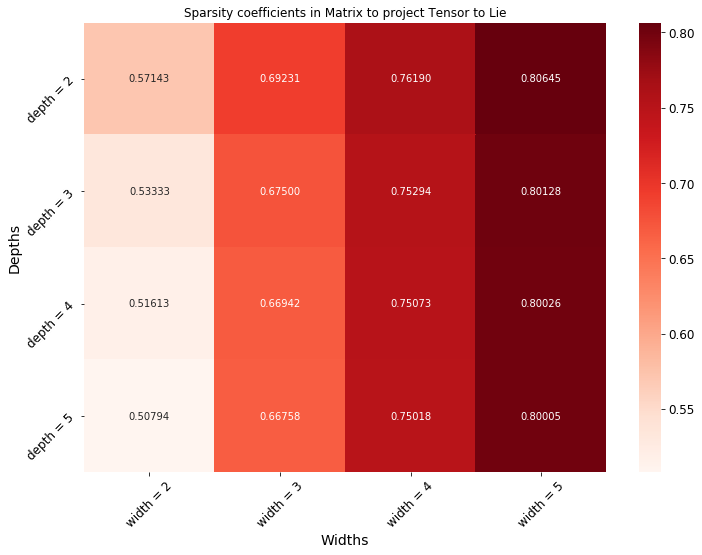

In [4]:
df = pd.DataFrame.from_dict(outer_dic)
df.columns = ['width = {}'.format(w) for w in widths]
df.index = ['depth = {}'.format(d) for d in depths]

df.rename_axis("depths", inplace=True)
df.rename_axis("widths", axis="columns", inplace=True)

# result = df.pivot(index=df.index, columns=df.columns, values='value')
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df.values, annot=True, cmap='Reds', fmt = '.5f')
ax.set_xticklabels(df.columns, rotation=45)
ax.set_yticklabels(df.index, rotation=45)
ax.set_xlabel("Widths")
ax.set_ylabel("Depths")
plt.title('Sparsity coefficients in Matrix to project Tensor to Lie')
plt.show()

In [4]:
outer_dic = {}
for width in widths:
    inner_dict = {}
    for depth in depths:
        pyt = EsigPyTorch()
        path = pyt.brownian(100, width)
        t = pyt.l2t(pyt.t2l(pyt.stream2sigtensor(pyt.brownian(100, width), depth)), width, depth)
        inner_dict[depth] = pyt.sparsity_coeff_l2t
    outer_dic[width] = inner_dict

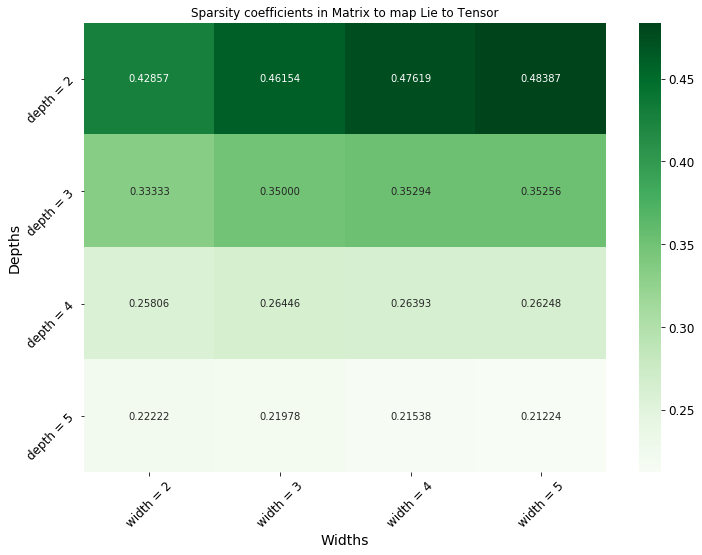

In [5]:
df = pd.DataFrame.from_dict(outer_dic)
df.columns = ['width = {}'.format(w) for w in widths]
df.index = ['depth = {}'.format(d) for d in depths]

df.rename_axis("depths", inplace=True)
df.rename_axis("widths", axis="columns", inplace=True)

# result = df.pivot(index=df.index, columns=df.columns, values='value')
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df.values, annot=True, cmap="Greens", fmt = '.5f')
ax.set_xticklabels(df.columns, rotation=45)
ax.set_yticklabels(df.index, rotation=45)
ax.set_xlabel("Widths")
ax.set_ylabel("Depths")
plt.title('Sparsity coefficients in Matrix to map Lie to Tensor')
plt.show()

# Timings

In [ ]:
width = 6
depth = 6
pyt = EsigPyTorch()
stream = pyt.brownian(100, width)

for d in range(2, depth+1):
    
    print('\n \n \n Depth: {} \n'.format(d))
    
    t = time()
    log_sigs = pyt.stream2sig(stream, d)
    print("time for sig in pytorch: {}".format(time() - t))

    t = time()
    log_sigs = tosig.stream2sig(stream.numpy(), d)
    print("time for sig in esig: {}".format(time() - t))

In [ ]:
width = 6
depth = 6
pyt = EsigPyTorch()
stream = pyt.brownian(100, width)

for d in range(2, depth+1):
    
    print('\n \n \n Depth: {} \n'.format(d))
    
    t = time()
    log_sigs = pyt.stream2logsig(stream, d)
    print("time for log-sig in pytorch: {}".format(time() - t))

    t = time()
    log_sigs = tosig.stream2logsig(stream.numpy(), d)
    print("time for log-sig in esig: {}".format(time() - t))